Load dataset

In [1]:
import pandas as pd
df = pd.read_csv('data.csv')
df_line2 = df.loc[df['ln_id'] == 2]

In [2]:
days = list(df_line2['dta_tm'])
days = sorted(list(set(days)))[:-1]
print(len(days),days[0],days[-1])

402 20210101 20220211


In [3]:
import warnings
warnings.filterwarnings("ignore")
data_dict = {str(d):dict() for d in days}
for day in days:
    d = df_line2.loc[df['dta_tm'] == day]
    d['in_ma5'] = d['in_flx_nr'].rolling(window=5).mean()
    d['in_ma10'] = d['in_flx_nr'].rolling(window=10).mean()
    d['in_ma15'] = d['in_flx_nr'].rolling(window=15).mean()
    d['out_ma5'] = d['out_flx_nr'].rolling(window=5).mean()
    d['out_ma10'] = d['out_flx_nr'].rolling(window=10).mean()
    d['out_ma15'] = d['out_flx_nr'].rolling(window=15).mean()
    dtms = list(d['dta_strt_tm'])
    tms = [str(t)[8:] for t in dtms]
    imin = tms.index('060000')
    imax = tms.index('230000')
    dtms = dtms[imin:imax+1]
    d_in = list(d['in_flx_nr'])[imin:imax+1]
    d_out = list(d['out_flx_nr'])[imin:imax+1]
    d_in_ma5 = list(d['in_ma5'])[imin:imax+1]
    d_in_ma10 = list(d['in_ma10'])[imin:imax+1]
    d_in_ma15 = list(d['in_ma15'])[imin:imax+1]
    d_out_ma5 = list(d['out_ma5'])[imin:imax+1]
    d_out_ma10 = list(d['out_ma10'])[imin:imax+1]
    d_out_ma15 = list(d['out_ma15'])[imin:imax+1]
    d_all = [d_in[i]+d_out[i] for i in range(len(d_in))]
    d_all_ma5 = [d_in_ma5[i]+d_out_ma5[i] for i in range(len(d_in_ma5))]
    d_all_ma10 = [d_in_ma5[i]+d_out_ma5[i] for i in range(len(d_in_ma10))]
    d_all_ma15 = [d_in_ma5[i]+d_out_ma5[i] for i in range(len(d_in_ma15))]

    data_dict[str(day)]['in'] = d_in
    data_dict[str(day)]['out'] = d_out
    data_dict[str(day)]['all'] = d_all


x_in = []
x_out = []
x_all = []
for d in days:
    x_in.append(data_dict[str(d)]['in'])
    x_out.append(data_dict[str(d)]['out'])
    x_all.append(data_dict[str(d)]['all'])
print(len(x_in),len(x_in[0]))


402 205


In [4]:
from darts import TimeSeries

tms = []
for i in range(6,23):
    for j in range(0,60,5):
        tms.append(str(i).zfill(2)+':'+str(j).zfill(2))
tms.append('23:00')
# print(tms)

input_chunk_length=48
output_chunk_length=12
chunk_length = input_chunk_length + output_chunk_length
X = []
Y = []
DAY = []
x_data = x_all
for i in range(len(x_data)):
    for j in range(len(x_data[i])-chunk_length):
        x = x_data[i][j:j+chunk_length]
        y = tms[j:j+chunk_length]
        X.append(x)
        Y.append(y)
        DAY.append(days[i])
print(len(X))
print(len(Y))

58290
58290


Preoessing 0
Preoessing 2000
Preoessing 4000
Preoessing 6000
Preoessing 8000
Preoessing 10000
Preoessing 12000
Preoessing 14000
Preoessing 16000
Preoessing 18000
Preoessing 20000
Preoessing 22000
Preoessing 24000
Preoessing 26000
Preoessing 28000
Preoessing 30000
Preoessing 32000
Preoessing 34000
Preoessing 36000
Preoessing 38000
Preoessing 40000
Preoessing 42000
Preoessing 44000
Preoessing 46000
Preoessing 48000
Preoessing 50000
Preoessing 52000
Preoessing 54000
Preoessing 56000
Preoessing 58000
58290
46632 11658


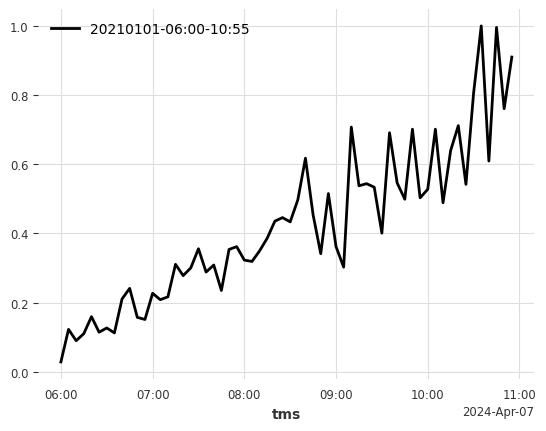

In [23]:
series = []
for i in range(len(X)):
    if i % 2000 == 0:
        print(f'Preoessing {i}')
    _df=pd.DataFrame()
    _df[str(DAY[i])+'-'+Y[i][0]+'-'+Y[i][-1]] = X[i]
    _df['tms'] = Y[i]
    series.append(TimeSeries.from_dataframe(_df,time_col='tms'))
print(len(series))
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MaxAbsScaler
scaler = Scaler(scaler=MaxAbsScaler())
series_scale = scaler.fit_transform(series)
for i in range(1):
    series_scale[i].plot()
VAL_LEN = int(0.2*len(series_scale))
train, val = series_scale[:-VAL_LEN], series_scale[-VAL_LEN:]
print(len(train),len(val))

Train model

In [26]:
from darts.models.forecasting.transformer_model import *
#input_chunk_length=48
#output_chunk_lengt=12
model = TransformerModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    random_state=42,
    batch_size=32,
    save_checkpoints=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0],
    },
    model_name=f'TransformerModel-{input_chunk_length}-{output_chunk_length}',
    force_reset=True
)
model.fit(series=train, val_series=val,epochs=10) # You can set a larger `epochs`

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 780   
------------------------------------------------------------
549 K     Trainable params
0         Non-trainable params
549 K     Total params
2.198     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1458/1458 [03:41<00:00,  6.58it/s, train_loss=0.00157, val_loss=0.00632]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1458/1458 [03:41<00:00,  6.57it/s, train_loss=0.00157, val_loss=0.00632]


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=12, random_state=42, batch_size=32, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}, model_name=TransformerModel-48-12, force_reset=True)

Test model

In [27]:
from darts.metrics import mape,mae,mse
import numpy as np
name = f'TransformerModel-{input_chunk_length}-{output_chunk_length}'
model_loaded =TransformerModel.load_from_checkpoint(name)
pred_series = []
actual_series = []
for i in range(len(val)):
    pred_series.append(val[i][:input_chunk_length])
    actual_series.append(val[i][input_chunk_length:])
pred_series=model_loaded.predict(series=pred_series,n=12)
# print(actual_series[0])
# print(pred_series[0])
mape=mape(actual_series,pred_series)
print(name+' mape:', np.array(mape).mean())
mae=mae(actual_series,pred_series)
print(name+' mae:', np.array(mae).mean())
mse=mse(actual_series,pred_series)
print(name+' mse:', np.array(mse).mean())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 365/365 [00:45<00:00,  7.94it/s]
TransformerModel-48-12 mape: 12.88458861765429
TransformerModel-48-12 mae: 0.055658228217879864
TransformerModel-48-12 mse: 0.00631953802280445
